In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.io.shapereader import Reader
from cartopy.feature.nightshade import Nightshade
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import datetime

In [3]:
import os
import numpy as np
import scipy.io as scio
usa_station_locations = scio.loadmat('autocorrelation_usa_locations.mat')
hkia_station_locations = scio.loadmat('autocorrelation_hkia_locations.mat')
import matplotlib.pyplot as plt
data = []
for i in range(usa_station_locations['lat_lon'].shape[0]):

    if (usa_station_locations['ac_n_lag_2'][i][0] !=0)&(~np.isnan(usa_station_locations['ac_n_lag_2'][i][0])):
        data.append([usa_station_locations['lat_lon'][i][0],usa_station_locations['lat_lon'][i][1],usa_station_locations['ac_n_lag_2'][i][0]])

for i in range(hkia_station_locations['lat_lon'].shape[0]):

    if (hkia_station_locations['ac_n_lag_2'][i][0] !=0)&(~np.isnan(hkia_station_locations['ac_n_lag_2'][i][0])):
        data.append([hkia_station_locations['lat_lon'][i][0],hkia_station_locations['lat_lon'][i][1],hkia_station_locations['ac_n_lag_2'][i][0]])
data = np.array(data)

In [4]:
from math import radians, cos, sin, asin, sqrt 

def haversine(lon1, lat1, lon2, lat2):
    # IDW插值方法
    R =  6372.8
    dLon = radians(lon2 - lon1)
    dLat = radians(lat2 - lat1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))
    d = R * c
    return d
def IDW(x, y, z, xi, yi):
    lstxyzi = []
    for p in range(len(xi)):
        lstdist = []
        for s in range(len(x)):
            d = (haversine(x[s], y[s], xi[p], yi[p]))
            lstdist.append(d)
        sumsup = list((1 / np.power(lstdist, 2)))
        suminf = np.sum(sumsup)
        sumsup = np.sum(np.array(sumsup) * np.array(z))
        u = sumsup / suminf
        xyzi = [xi[p], yi[p], u]

        lstxyzi.append(xyzi)
    return(lstxyzi)

def interp_data(extent,grid,lon,lat,known_data):
    Lon1 = extent[0]
    Lon2 = extent[1]
    Lat1 = extent[2]
    Lat2 = extent[3]
    grid_lon_list=np.linspace(Lon1,Lon2,grid)
    grid_lat_list=np.linspace(Lat1,Lat2,grid)
    # 转换成网格
    newlon, newlat = np.meshgrid(grid_lon_list, grid_lat_list)
    #数据扁平化
    grid_lon_list = newlon.flatten().tolist()
    grid_lat_list = newlat.flatten().tolist()
    sta_data=np.array(IDW(lon,lat,known_data,grid_lon_list,grid_lat_list))
    sta_lon=sta_data[:,0].reshape(grid,grid)
    sta_lat=sta_data[:,1].reshape(grid,grid)
    sta_idw=sta_data[:,2].reshape(grid,grid)
    return sta_lon,sta_lat,sta_idw

In [5]:
extent_usa = [-180, -40,0, 90]
grid_usa = 100
lon = (data[:,1]).tolist()
lat = data[:,0].tolist()
known_data = data[:,2]
sta_lon_usa,sta_lat_usa,sta_idw_usa = interp_data(extent_usa,grid_usa,lon,lat,known_data)

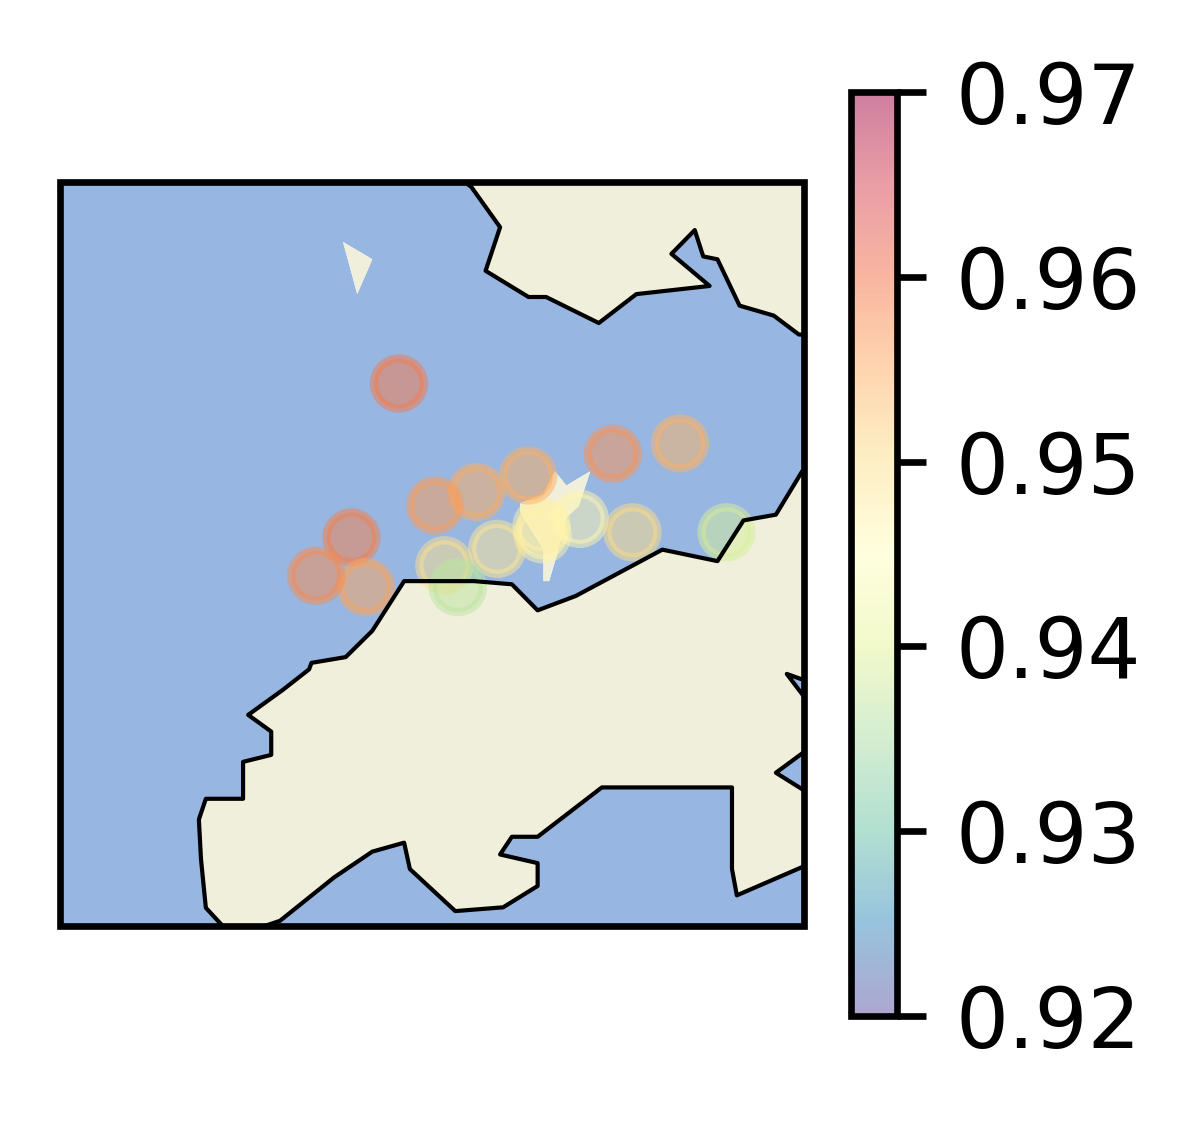

In [6]:

def plot_hkia_maxzoom(ax):
    ax.add_feature(cfeature.OCEAN.with_scale('10m'))
    ax.add_feature(cfeature.LAND.with_scale('10m'))
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'),lw=0.5)
    # ax.add_feature(cfeature.BORDERS.with_scale('10m'),lw=0.1)
    # ax.set_xticks([ 0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
    # ax.set_yticks([ -90,-60, -30, 0, 30, 60,90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(color = 'gray',direction='in')
    ax.set_extent([113.8,114.0,22.2,22.4],crs = ccrs.PlateCarree()) #[113.8,114.0,22.2,22.4]
    cf = ax.scatter(data[:,1],data[:,0],
                c=data[:,2],cmap='Spectral_r',alpha=0.5)
    cbar = fig.colorbar(mappable=cf)
    cbar.mappable.set_clim([0.92,0.97])
%matplotlib inline
fig = plt.figure(figsize=(2, 2), dpi=600)  
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
plot_hkia_maxzoom(ax)
# plt.savefig('D:\\HKG1\\revise2\\figures\\hkia_ss_map.pdf')

In [7]:
import xarray as xr
import numpy as np
import pandas as pd
import salem

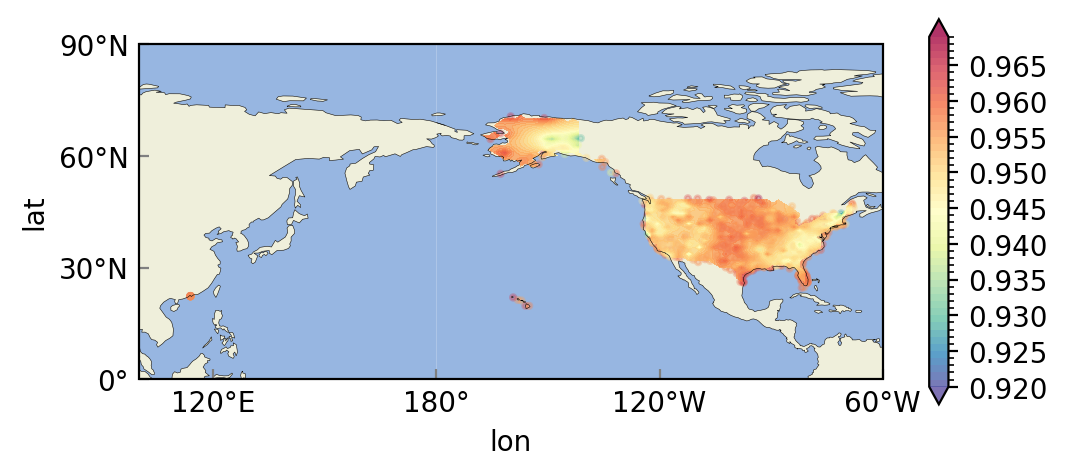

In [8]:
lat = sta_lat_usa[:,0]
lon = sta_lon_usa[0,:]
df = pd.DataFrame(index=lat,columns=lon,data=sta_idw_usa)
df.index.name = 'lat'
df.columns.name = 'lon'
usa_da = xr.DataArray(df
                      )
temp = usa_da.isel()
fig = plt.figure(figsize=(6, 2.5), dpi=200)  
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cfeature.OCEAN)#.with_scale('10m')
ax.add_feature(cfeature.LAND)#.with_scale('10m')
ax.add_feature(cfeature.COASTLINE,lw=0.2)#.with_scale('10m')
# ax.add_feature(cfeature.BORDERS,lw=0.1)
ax.set_xticks([ 0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
ax.set_yticks([ -90,-60, -30, 0, 30, 60,90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.tick_params(color = 'gray',direction='in')
ax.set_extent([100,300,0,90],crs = ccrs.PlateCarree()) 
ax.scatter(data[:,1]-180,data[:,0],
                c=data[:,2],cmap='Spectral_r',alpha=0.3,s=4)
shp_path = '.\\USA123\\USA_adm2.shp'
t = temp.salem.roi(shape = shp_path)
levels = np.arange(0.92, 0.97, 0.001)
t.plot.contourf(
    ax=ax, 
    cmap='Spectral_r', 
    levels = levels,
    transform=ccrs.PlateCarree(), 
    extend='both',alpha = 0.8
)
